In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import numpy as np
from IPython import display

from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
is_channels_first = False
buf = np.load('./data/resnet3d_data_channel_last_updown_and_wipe_frame-3_stride123_gray_100x100_20191016.npz')

X = buf["X"].astype("f4")
Y = buf["Y"].astype("f4")
del buf

#Y = keras.utils.to_categorical(Y, 2, dtype="f2").astype("f2")
X_train, X_val,  Y_train,  Y_val = train_test_split(X, Y, train_size=0.8, shuffle=True)
#X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, train_size=0.8, shuffle=True)

In [3]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
          [
              tf.keras.layers.InputLayer(input_shape=(3, 100, 100, 1)),
              tf.keras.layers.Conv3D(filters=32, kernel_size=3, strides=(3,2,2), padding="same", activation='relu'),
              tf.keras.layers.Conv3D(filters=64, kernel_size=3, strides=(1,2,2), padding="same", activation='relu'),
              tf.keras.layers.Flatten(),
              # No activation
              tf.keras.layers.Dense(latent_dim + latent_dim),
          ]
        )
        
        self.generative_net = tf.keras.Sequential(
            [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=1*25*25*64, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(1, 25, 25, 64)),
              tf.keras.layers.Conv3DTranspose(filters=64, kernel_size=3, strides=(1,2,2), padding="SAME", activation='relu'),
              tf.keras.layers.Conv3DTranspose(filters=32, kernel_size=3, strides=(3,2,2), padding="SAME", activation='relu'),
              # No activation
              tf.keras.layers.Conv3DTranspose(filters=1, kernel_size=1, strides=(1,1,1), padding="SAME"),
            ]
        )
        
    #@tf.function
    #def call(self, x):
    #    for layer in self._layers:
    #        if isinstance(layer, list):
    #            for l in layer:
    #                x = l(x)    
    #        else:
    #            x = layer(x)
    #    return x
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
          eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
          probs = tf.sigmoid(logits)
          return probs

        return logits

In [4]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  
  #cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  cross_ent = tf.sqrt(tf.reduce_mean((x_logit - x)**2))
  
  #logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpx_z = -tf.reduce_sum(cross_ent)
  
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [5]:
latent_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [6]:
TRAIN_BUF = X_train.shape[0]
BATCH_SIZE = 32
TEST_BUF = X_val.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(X_val).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [7]:
#generate_and_save_images(model, 0, random_vector_for_generation)
epochs = 1000
loss_list = []
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    loss_list.append(elbo)
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    #generate_and_save_images(model, epoch, random_vector_for_generation)

Epoch: 1000, Test set ELBO: -0.09077749401330948, time elapse for current epoch 7.4877166748046875


In [15]:
xx = [v for v in range(1000)]
yy = []
for loss in loss_list:
    yy.append(loss.numpy())

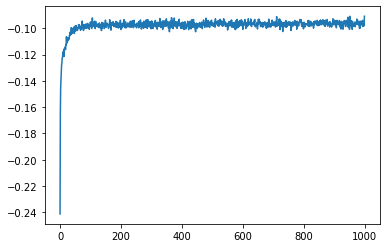

In [16]:
plt.plot(xx, yy)